# Author

Daniel Soto

# Introduction

This notebook creates the publication plot for a price duration curve or specific fuel consumption curve.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import WP19_analysis as wpa
import statsmodels.api as sm

/Users/dsoto/miniconda3/envs/wp19/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
gen_data = pd.read_csv('../data_sheets/generator_data.csv')
gen_data['load_kVA'] = gen_data['rated_power_kVA'] * gen_data['percent_load'] / 100
y = gen_data['fuel_consumption_lph']
X = gen_data[['rated_power_kVA', 'load_kVA']]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

def get_fuel_rate(power, load):
    return model.params['const'] + model.params['rated_power_kVA'] * power + model.params['load_kVA']* load

(2,)
(2,)
(2,)


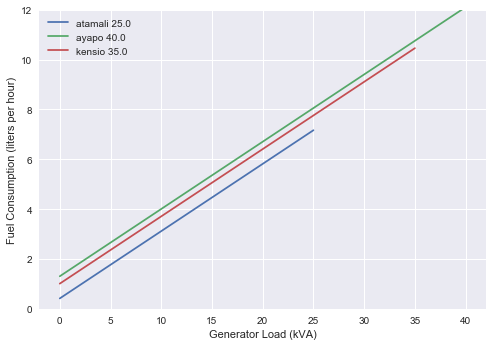

In [4]:
# plot fuel consumption for each village compared to load
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    load = np.linspace(0, 1, 2) * rfd['genset_rating_kVA']
    power = rfd['genset_rating_kVA']
    y = get_fuel_rate(power, load)
    plt.plot(load, y, label=vname + ' ' + str(rfd['genset_rating_kVA']))
    print(y.shape)

plt.legend()
plt.ylim((0, 12))
plt.xlabel('Generator Load (kVA)')
plt.ylabel('Fuel Consumption (liters per hour)')
plt.show()

Generator Fuel Rate Curves


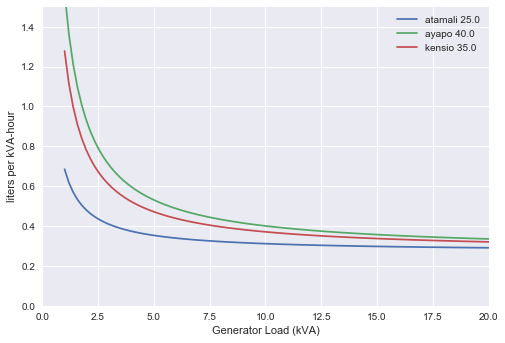

In [5]:
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    load = np.linspace(0.05, 1.0, 100) * 20.0
    hours = 1.0
    load_hours = load * hours
    fuel_rate = get_fuel_rate(rfd['genset_rating_kVA'], load)
    fuel = fuel_rate * hours
    heat_rate = fuel / load_hours
    plt.plot(load, heat_rate, label=vname + ' ' + str(rfd['genset_rating_kVA']))

print('Generator Fuel Rate Curves')
plt.xlim((0, 20))
plt.ylim((0, 1.5))
plt.legend()
plt.xlabel('Generator Load (kVA)')
plt.ylabel('liters per kVA-hour')
plt.show()

Load Duration Curves (kVA)


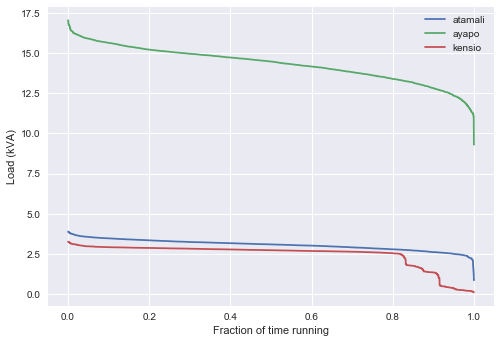

In [ ]:
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    kVA.sort()
    kVA = kVA[::-1]
    index = np.linspace(0, 1, len(kVA))
    plt.plot(index, kVA, label=vname)

print('Load Duration Curves (kVA)')
plt.legend()
plt.xlabel('Fraction of time running')
plt.ylabel('Load (kVA)')
plt.show()

In [ ]:
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA / rfd['genset_rating_kVA']
    kVA = kVA[kVA != 0.0]
    kVA.sort()
    kVA = kVA[::-1]
    index = np.linspace(0, 1, len(kVA))
    plt.plot(index, kVA, label=vname)

print('Load Duration Curves (percent rated load)')
plt.legend()
plt.xlabel('Fraction of time running')
plt.ylabel('Percent of rated load')
plt.show()

In [ ]:
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    # create fuel rate time series from kVA data
    fuel_rate = get_fuel_rate(rfd['genset_rating_kVA'], kVA)
    fuel_per_kVA_hour = fuel_rate / kVA
    fuel_per_kVA_hour.sort()
    fuel_per_kVA_hour = fuel_per_kVA_hour[::-1]
    index = np.linspace(0, 1, len(fuel_per_kVA_hour))
    plt.plot(index, fuel_per_kVA_hour,
             label=vname)

print('Specific Fuel Consumption Duration Curves')
plt.legend()
plt.xlabel('Fraction of Running Time')
plt.ylabel('Specific Fuel Consumption (liter per kVA-hour)')
plt.ylim((0,2))
plt.savefig('../plots/specific_fuel_consumption_duration.png')
plt.show()


In [ ]:
data = []
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    fuel_rate = get_fuel_rate(rfd['genset_rating_kVA'], kVA)
    fuel_per_kVA_hour = fuel_rate / kVA
    data.append({'village' : vname,
                 'max fuel rate' : fuel_rate.max(),
                 'min fuel rate' : fuel_rate.min(),
                 'max fuel per kVA' : fuel_per_kVA_hour.max(),
                 'min fuel per kVA' : fuel_per_kVA_hour.min(),
                 'mean fuel per kVA' : fuel_per_kVA_hour.mean(),
                 'max kVA' : kVA.max(),
                 'min kVA' : kVA.min(),
                 'capacity' : rfd['genset_rating_kVA']})
pd.DataFrame(data)